# Rankine cycle

## Analyzing a Rankine Cycle with Irreversibilities

<img src='./assets/images/5_Rankine_ideal.png' />

---
### Importing packages

In [1]:
import cantera as ct

import numpy as np
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
from functions import plot_T_s

### Problem statement and hypotesis

Reconsider the vapor power cycle, but include in the analysis that the turbine and the pump each have an isentropic efficiency of 85%. 

**Engineering Model**
1. Each component of the cycle is analyzed as a control volume at steady state.
2. The working fluid passes through the boiler and condenser at constant pressure. Saturated vapor enters the turbine. The condensate is saturated at the condenser exit.
3. The turbine and pump each operate adiabatically with an efficiency of 85%.
4. Kinetic and potential energy effects are negligible.

**Determine for the modified cycle**
1. the thermal efficiency, 
1. the mass flow rate of steam, in kg/h, for a net power output of 100 MW, 
1. the rate of heat transfer $\dot{Q}_{in}$ into the working fluid as it passes through the boiler, in MW, 
1. the rate of heat transfer $\dot{Q}_{out}$ from the condensing steam as it passes through the condenser, in MW, 
1. the mass flow rate of the condenser cooling water, in kg/h, if cooling water enters the condenser at 15°C and exits as 35°C.

---
Owing to the presence of irreversibilities during the expansion of the steam through the turbine, there is an increase in specific entropy from turbine inlet to exit.

Similarly, there is an increase in specific entropy from pump inlet to exit. 

Let us begin the analysis by fixing each of the principal states.

**State 1** stays the same:

In [2]:
eta_is = 0.85

W_cycle = 100
p4 = p1 = 8e6
p2 = p3 = 8e3

# create an object representing water
w = ct.Water()

# reference state (triple point; liquid state)
w.TQ = w.min_temp, 0
uf0 = w.int_energy_mass / 1.0e3
hf0 = w.enthalpy_mass / 1.0e3
sf0 = w.entropy_mass / 1.0e3
pv0 = w.P * w.v / 1.0e3

w.PQ = p1, 0
T0 = w.T
s0 = w.s
h0 = w.h

w.PQ = p1, 1
T1 = w.T
s1 = w.s
h1 = w.h


# to compare with steam tables change referance state
def print_s(s):
    print(round(s / 1e3 - sf0, 2), "kJ/kg K")


def print_h(h):
    print(round(h / 1e3 - hf0 - pv0, 2), "kJ/kg")


print_s(s1)
print_h(h1)

5.74 kJ/kg K
2758.13 kJ/kg


The specific enthalpy at the turbine exit, **state 2**, can be determined using the isentropic turbine efficiency,

$$ \eta_t = \frac{\dot{W}_t / \dot{m}}{(\dot{W}_t / \dot{m})_s} = \frac{h_1 - h_2}{h_1 - h_{2s}} $$

where $h_{2s}$ is the specific enthalpy at **state $2_s$** on the accompanying T–s diagram.

In [3]:
# let's compute h2s
s2s = s1

# sf
w.PQ = p2, 0
T2 = w.T
sf = w.s

# sg
w.PQ = p2, 1
sg = w.s

x2s = (s2s - sf) / (sg - sf)

w.PQ = p2, x2s
h2s = w.h

print_h(h2s)

# thus, h2
h2 = h1 - eta_is * (h1 - h2s)

print_h(h2)

w.HP = h2, p2
s2 = w.s

1794.87 kJ/kg
1939.36 kJ/kg


**State 3** can be determained as for the ideal case:

In [4]:
w.PQ = p3, 0

T3 = w.T
h3 = w.h
s4s = s3 = w.s

print_h(h3)

174.03 kJ/kg


To determine the specific enthalpy at the pump exit, **state 4**, reduce mass and energy rate balances for a control volume around the pump to obtain $\dot{W}_p / \dot{m} = h4 − h3$. 
On rearrangement, the specific enthalpy at state 4 is 
$$ h4 = h3 + \dot{W}_p / \dot{m}$$

To determine h4 from this expression requires the pump work.
Pump work can be evaluated using the isentropic pump efficiency:

$$ \frac{\dot{W}_p}{\dot{m}} = \frac{v_3 \cdot (p_4 - p_3)}{\eta_p} $$

In [5]:
w.PQ = p3, 0
v3 = w.v

Wp_m = v3 * (p4 - p3) / eta_is

print(round(Wp_m / 1e3, 2), "kJ/kg")

9.48 kJ/kg


The specific enthalpy at the pump exit is then

In [6]:
h4 = h3 + Wp_m

w.HP = h4, p1
T4 = w.T
s4 = w.s

print_h(h4)

w.SP = s4s, p1
h4s = w.h
s4s = w.s
T4s = w.T

183.52 kJ/kg


Let'start answeing the questions

1) the thermal efficiency

The net power developed by the cycle is

$$ \dot{W}_{cycle} = \dot{W}_t - \dot{W}_p = \dot{m} \cdot [(h_1 - h_2) - (h_4 - h_3)] $$

The rate of heat transfer to the working fluid as it passes through the boiler is

$$ \dot{Q}_{in} = \dot{m} \cdot (h_1 - h_4) $$

Thus, the thermal efficiency is

$$ \eta = \frac{(h_1 - h_2)-(h_4 - h_3)}{h_1 - h_4} $$

In [7]:
eta = (h1 - h2 - h4 + h3) / (h1 - h4)

print(round(eta * 100, 1), "%")

31.4 %


2) the mass flow rate of steam, in kg/h, for a net power output of 100 MW

With the net power expression of part 1), the mass flow rate of the steam is

$$ \dot{m} = \frac{\dot{W}_{cycle}}{(h_1 - h_2)-(h_4-h_3)} $$

In [8]:
m = W_cycle * 1e6 / (h1 - h2 - h4 + h3)  # kg/s

print(round(m * 3600, 2), "kg/h")

444837.5 kg/h


3) The turbine and pump each operate adiabatically with an efficiency of 85%

With the expression for $\dot{Q}_{in}$ from part 1) and previously determined specific enthalpy values

In [9]:
Q_in = m * (h1 - h4)

print(round(Q_in / 1e6, 2), "MW")

318.13 MW


4) the rate of heat transfer $\dot{Q}_{out}$ from the condensing steam as it passes through the condenser, in MW

In [10]:
Q_out = m * (h2 - h3)

print(round(Q_out / 1e6, 2), "MW")

218.13 MW


5) the mass flow rate of the condenser cooling water, in kg/h, if cooling water enters the condenser at 15°C and exits as 35°C

The mass flow rate of the cooling water can be determined from

$$ \dot{m}_{cw} = \frac{\dot{m} \cdot (h_2 - h_3)}{(h_{cw, out} - h_{cw, in})} $$

In [11]:
w.TQ = 15 + 273.15, 0
h_cw_in = w.h

w.TQ = 35 + 273.15, 0
h_cw_out = w.h

m_cw = m * (h2 - h3) / (h_cw_out - h_cw_in)

print(f"{round(m_cw * 3600, 2)} kg/h")

9384614.98 kg/h


Let's visualize the plot

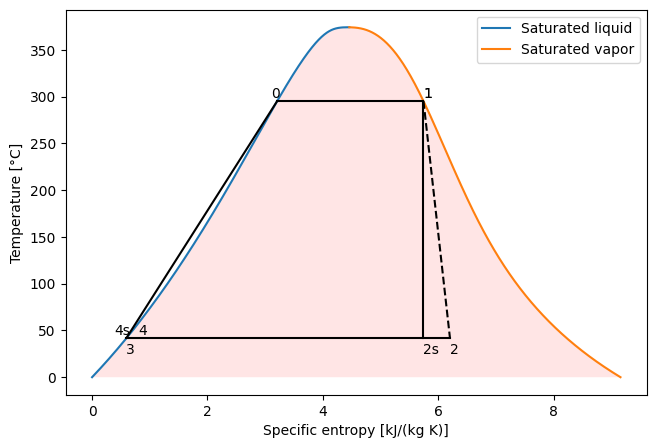

In [12]:
fig, ax = plot_T_s(w)

# 1-2
ax.annotate("1", (s1 / 1e3 - sf0, T1 - 270))
ax.annotate("2", (s2 / 1e3 - sf0, T2 - 290))
ax.plot([s1 / 1e3 - sf0, s2 / 1e3 - sf0], [T1 - 273.15, T2 - 273.15], "--k")

# 1-2s
ax.annotate("1", (s1 / 1e3 - sf0, T1 - 270))
ax.annotate("2s", (s2s / 1e3 - sf0, T2 - 290))
ax.plot([s1 / 1e3 - sf0, s2s / 1e3 - sf0], [T1 - 273.15, T2 - 273.15], "k")

# 2-3
ax.annotate("3", (s3 / 1e3 - sf0, T3 - 290))
ax.plot([s2 / 1e3 - sf0, s3 / 1e3 - sf0], [T2 - 273.15, T3 - 273.15], "k")

# 3-4s
ax.annotate("4s", (s4s / 1e3 - sf0 - 0.2, T4s - 270))
ax.plot([s3 / 1e3 - sf0, s4s / 1e3 - sf0], [T3 - 273.15, T4s - 273.15], "k")

# 3-4
ax.annotate("4", (s4 / 1e3 - sf0 + 0.2, T4 - 270))
ax.plot([s3 / 1e3 - sf0, s4 / 1e3 - sf0], [T3 - 273.15, T4 - 273.15], "--k")

# 4-0
ax.annotate("0", (s0 / 1e3 - sf0 - 0.1, T0 - 270))
ax.plot([s4 / 1e3 - sf0, s0 / 1e3 - sf0], [T4 - 273.15, T0 - 273.15], "k")

# 0-1
ax.plot([s0 / 1e3 - sf0, s1 / 1e3 - sf0], [T0 - 273.15, T1 - 273.15], "k")